# Model Implementation

Loading data

Data Cleaning

Phrase Modeling: Bi-grams and Tri-grams
    
Data transformation: Corpus and Dictionary
    
Base Model

Hyperparameter Tuning

Final Model

Visualize Results

In [2]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(400)
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm


In [2]:
# Importing modules
import pandas as pd

# Read data 
df=pd.read_excel("sdgs_topic modelling.xlsx")
# Print head
df.head(1)

,Organization_Name,Organization_City,Organization_Country,Organization_Website,Organization Linkedin,Short_description,Organization_Industries,Investor,Type_investment,Long_description
0,Affect Therapeutics,New York,United States,https://www.affecttherapeutics.com/,https://www.linkedin.com/company/affect-therap...,Affect Therapeutics is using mobile technology...,Health Care,Acumen,SDGs,Affect is using digital technology to deliver ...


In [3]:
train, test= train_test_split(df,test_size=0.1, random_state=0)

# Remove punctuation/lower casing


In [4]:
# Load the regular expression library
import re
# Remove punctuation
train['Long_description_processed'] = train['Long_description'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the descriptions to lowercase
train['Long_description_processed'] = train['Long_description_processed'].map(lambda x: x.lower())
# Print out the first rows of descriptions
train['Long_description_processed'].head()

C:\Users\daian\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\daian\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


141     forceclouds develops enterprise software inten...
487     jsc credo bank (credo) successfully operating ...
678     our vision is to offer pedagogically different...
49              the path towards upward economic mobility
1178    sustainable restaurant group is a collection o...
Name: Long_description_processed, dtype: object

# Tokenize words and further clean-up text


In [5]:
import gensim
from gensim.utils import simple_preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data = train.Long_description_processed.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:30])

['forceclouds', 'develops', 'enterprise', 'software', 'intended', 'to', 'provide', 'simple', 'safe', 'efficient', 'and', 'compliant', 'information', 'automation']


# Phrase Modeling: Bigram and Trigram Models

Bigrams are two words frequently occurring together in the document. 



In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Remove Stopwords, Make Bigrams and Lemmatize


In [7]:
# NLTK Stop words
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [8]:
import spacy
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['forcecloud', 'develop', 'enterprise', 'software', 'intend', 'provide', 'simple', 'safe', 'efficient', 'compliant', 'information', 'automation']]


# Data Transformation: Corpus and Dictionary
The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. 

In [9]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized


In [10]:
'''
Checking dictionary created
'''
count = 0
for k, v in id2word.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 automation
1 compliant
2 develop
3 efficient
4 enterprise
5 forcecloud
6 information
7 intend
8 provide
9 safe
10 simple


In [11]:
id2word.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)

In [12]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]]


# Base Model


In [13]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=5, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

# View the topics in LDA model


In [14]:
from pprint import pprint
# Print the Keyword in the 5 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.021*"power" + 0.020*"energy" + 0.018*"payment" + 0.017*"online" + '
  '0.015*"digital" + 0.015*"mobile" + 0.014*"consumer" + 0.013*"africa" + '
  '0.013*"solar" + 0.013*"app"'),
 (1,
  '0.044*"social" + 0.019*"support" + 0.018*"community" + 0.017*"impact" + '
  '0.016*"engagement" + 0.014*"need" + 0.013*"program" + 0.013*"change" + '
  '0.013*"family" + 0.012*"share"'),
 (2,
  '0.026*"datum" + 0.022*"health" + 0.018*"healthcare" + 0.016*"farmer" + '
  '0.016*"care" + 0.014*"work" + 0.013*"food" + 0.013*"improve" + '
  '0.013*"patient" + 0.012*"industry"'),
 (3,
  '0.019*"development" + 0.015*"student" + 0.015*"access" + 0.014*"security" + '
  '0.014*"client" + 0.013*"work" + 0.012*"learning" + 0.011*"school" + '
  '0.011*"focus" + 0.011*"network"'),
 (4,
  '0.031*"finance" + 0.026*"credit" + 0.025*"india" + 0.024*"small" + '
  '0.020*"insurance" + 0.020*"loan" + 0.019*"bank" + 0.019*"access" + '
  '0.015*"micro" + 0.014*"urban"')]


# Compute Model Perplexity and Coherence Score


In [15]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4245952905703936


In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -5.921062964039574


In [17]:
#convert gensim log_perplexity to the perlexity value from scikitlearn, to make them comparable 
np.exp(-1.*lda_model.log_perplexity(corpus))

372.8115879402722

# Hyperparameter Tuning


Number of Topics (K)

Dirichlet hyperparameter alpha: Document-Topic Density

Dirichlet hyperparameter eta: Word-Topic Density



In [34]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

#  call the function, and iterate it over the range of topics, alpha, and eta parameter values
#takes a while to get final results

In [35]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
eta = list(np.arange(0.01, 1, 0.3))
eta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Eta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in eta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Eta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results2ETA.csv', index=False)
    pbar.close()

100%|██████████| 540/540 [1:56:53<00:00, 12.99s/it]


In [37]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values=[]
    model_list=[]
    for num_topics in range (start, limit, step):
        model=gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, random_state=100, chunksize=200, 
                                      passes=10, per_word_topics=True, id2word=id2word)
        model_list.append(model)
        coherencemodel=CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence="c_v")
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
        

In [38]:
model_list, coherence_values=compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, 
                                                      start=2, limit=8,step=1)


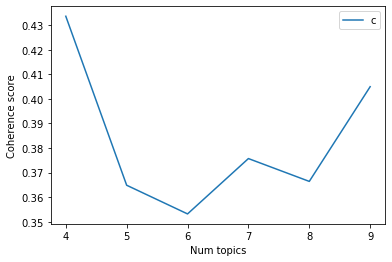

In [44]:
#show graph
from matplotlib import pyplot as plt
limit=10; start=4; step=1;
x=range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc="best")
#plt.show()
plt.savefig('Charts\Coherencenumbertopicsgensim_'+'.png')

In [45]:
#print the coherence score
for m, cv in zip(x, coherence_values):
    print("Num topics=", m, "has coherence value of", round(cv,4))

Num topics= 4 has coherence value of 0.4337
Num topics= 5 has coherence value of 0.3649
Num topics= 6 has coherence value of 0.3532
Num topics= 7 has coherence value of 0.3757
Num topics= 8 has coherence value of 0.3664
Num topics= 9 has coherence value of 0.405


In [13]:
#final LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=7, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.31,
                                           eta=0.31)

In [19]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4521730861917969


In [20]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -5.968836583187628


In [21]:
#convert gensim log_perplexity to the perlexity value from scikitlearn, to make them comparable 
np.exp(-1.*lda_model.log_perplexity(corpus))


391.0465672134156

In [25]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

C:\Users\daian\anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [26]:
lda_viz = gensimvis.prepare(lda_model, corpus, id2word)

C:\Users\daian\AppData\Roaming\Python\Python37\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [27]:
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.109575  0.008991       1        1  17.269451
0      0.055089 -0.112261       2        1  15.711294
6     -0.075865 -0.014201       3        1  14.885128
5     -0.033483  0.002639       4        1  14.780773
3      0.030111 -0.091307       5        1  14.317466
4      0.174261  0.080477       6        1  12.787806
1     -0.040539  0.125660       7        1  10.248082, topic_info=               Term        Freq       Total Category  logprob  loglift
90           social  110.000000  110.000000  Default  30.0000  30.0000
192         finance   85.000000   85.000000  Default  29.0000  29.0000
285          energy   76.000000   76.000000  Default  28.0000  28.0000
148          credit   71.000000   71.000000  Default  27.0000  27.0000
239          health  113.000000  113.000000  Default  26.0000  26.0000
..              ...         ...         ...      ...      ...      ...
180         include   13.536961   75.551772   Topic7  -4.7269   0.5587
97            datum   15.022290  141.441136   Topic7  -4.6228   0.0357
101  infrastructure   12.088861   40.795119   Topic7  -4.8400   1.0618
115            time   12.488166   56.640746   Topic7  -4.8075   0.7661
52            share   12.166262   45.647848   Topic7  -4.8336   0.9558

[349 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
207       1  0.145031  accelerate
207       2  0.145031  accelerate
207       3  0.048344  accelerate
207       4  0.193375  accelerate
207       7  0.435094  accelerate
...     ...       ...         ...
56        6  0.014837        work
56        7  0.051930        work
340       2  0.097561       young
340       3  0.617884       young
340       7  0.227641       young

[1316 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 7, 6, 4, 5, 2])

In [28]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.034*"online" + 0.026*"digital" + 0.023*"payment" + 0.022*"consumer" + 0.020*"mobile" + 0.016*"experience" + 0.015*"app" + 0.012*"access" + 0.012*"easy" + 0.011*"connect"
Topic: 1 
Words: 0.057*"social" + 0.025*"application" + 0.025*"impact" + 0.020*"security" + 0.019*"support" + 0.015*"software" + 0.015*"network" + 0.014*"enterprise" + 0.014*"program" + 0.014*"change"
Topic: 2 
Words: 0.028*"farmer" + 0.022*"food" + 0.021*"care" + 0.020*"datum" + 0.016*"drive" + 0.015*"develop" + 0.015*"home" + 0.014*"work" + 0.013*"use" + 0.013*"produce"
Topic: 3 
Words: 0.026*"development" + 0.023*"student" + 0.018*"school" + 0.018*"work" + 0.016*"learn" + 0.016*"access" + 0.016*"employee" + 0.015*"learning" + 0.015*"education" + 0.015*"create"
Topic: 4 
Words: 0.041*"finance" + 0.034*"credit" + 0.030*"loan" + 0.029*"india" + 0.020*"access" + 0.020*"urban" + 0.019*"lending" + 0.017*"bank" + 0.017*"rural" + 0.017*"institution"
Topic: 5 
Words: 0.033*"energy" + 0.030*"power" + 0.019*

In [30]:
#topic contribution per document
df_docu_topics=pd.DataFrame(lda_model.get_document_topics(corpus))
df_docu_topics

,0,1,2,3,4,5,6
0,"(0, 0.03217309)","(1, 0.037287343)","(2, 0.79994994)","(3, 0.032144427)","(4, 0.03162017)","(5, 0.033382054)","(6, 0.033442944)"
1,"(3, 0.8407157)","(4, 0.1340737)",None,None,None,None,None
2,"(2, 0.3618778)","(3, 0.43174908)","(4, 0.16601333)","(5, 0.010193422)","(6, 0.010254331)",None,None
3,"(0, 0.09850999)","(1, 0.09785562)","(2, 0.09785903)","(3, 0.100541696)","(4, 0.3943607)","(5, 0.112618685)","(6, 0.09825431)"
4,"(0, 0.018077021)","(1, 0.6091882)","(2, 0.29876631)","(3, 0.015342933)","(4, 0.014283815)","(5, 0.015553755)","(6, 0.02878797)"
...,...,...,...,...,...,...,...
1074,"(0, 0.90875703)","(1, 0.010968347)","(2, 0.010853385)","(3, 0.03490639)","(4, 0.011183948)","(5, 0.012444162)","(6, 0.010886761)"
1075,"(0, 0.5005317)","(1, 0.07448208)","(2, 0.109860025)","(3, 0.08161902)","(4, 0.07447046)","(5, 0.07955)","(6, 0.07948675)"
1076,"(0, 0.061337326)","(1, 0.06752863)","(2, 0.061037336)","(3, 0.62237835)","(4, 0.060071733)","(5, 0.06528505)","(6, 0.06236163)"
1077,"(0, 0.17186546)","(1, 0.014887316)","(2, 0.10480714)","(3, 0.014094501)","(4, 0.014250851)","(5, 0.66591036)","(6, 0.014184347)"


In [37]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.8000,"farmer, food, care, datum, drive, develop, hom...",forceclouds develops enterprise software inten...
1,1,3.0,0.8407,"development, student, school, work, learn, acc...",jsc credo bank (credo) successfully operating ...
2,2,3.0,0.4317,"development, student, school, work, learn, acc...",our vision is to offer pedagogically different...
3,3,4.0,0.3945,"finance, credit, loan, india, access, urban, l...",the path towards upward economic mobility
4,4,1.0,0.6088,"social, application, impact, security, support...",sustainable restaurant group is a collection o...
5,5,2.0,0.7665,"farmer, food, care, datum, drive, develop, hom...",corticare provides continuous eeg services for...
6,6,2.0,0.3421,"farmer, food, care, datum, drive, develop, hom...",metaweb technologies was spun out of applied m...
7,7,0.0,0.4353,"online, digital, payment, consumer, mobile, ex...",guiabolso offers both financial management and...
8,8,4.0,0.3721,"finance, credit, loan, india, access, urban, l...",fdl is a nonprofit microfinance institution th...
9,9,6.0,0.5856,"health, healthcare, insurance, datum, life, me...",what do we do we carry out aerial inspection a...


In [44]:
df_dominant_topic.to_excel("df_dominant_topic_gensim.xlsx")

In [42]:
df_topic_distribution = df_dominant_topic['Dominant_Topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0.0,200
1,2.0,168
2,6.0,163
3,3.0,156
4,5.0,151
5,4.0,127
6,1.0,114


In [43]:
df_topic_distribution.to_excel("df_topic_distribution_gensim.xlsx")

In [40]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(7)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,2.0,"farmer, food, care, datum, drive, develop, hom...",200.0,0.1854
1.0,3.0,"development, student, school, work, learn, acc...",114.0,0.1057
2.0,3.0,"development, student, school, work, learn, acc...",168.0,0.1557
3.0,4.0,"finance, credit, loan, india, access, urban, l...",156.0,0.1446
4.0,1.0,"social, application, impact, security, support...",127.0,0.1177
5.0,2.0,"farmer, food, care, datum, drive, develop, hom...",151.0,0.1399
6.0,2.0,"farmer, food, care, datum, drive, develop, hom...",163.0,0.1511


In [31]:
df_docu_topics.to_excel("df_docu_topics_gensim.xlsx")

# Tranform data_test and apply trained model per random SMEs

In [96]:
data_test=test.Long_description.values.tolist()

In [97]:
# Load the regular expression library
import re
# Remove punctuation
test['Long_description_processed'] = test['Long_description'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the descriptions to lowercase
test['Long_description_processed'] = test['Long_description_processed'].map(lambda x: x.lower())
# Print out the first rows of descriptions
test['Long_description_processed'].head(12)

C:\Users\daian\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\daian\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


198     shaw healthcare is the health and social care ...
328     preempt secures all workforce identities every...
45      cotton ginning company improve household incom...
263     gamerdna is a social network for online gamers...
621     acep cameroun is a microfinance institution sp...
520     our vision is running water in every home as a...
186     ways to wellness provides support to people in...
987     tarfin is a leading fintech company that provi...
1107    skillsmart - a growing technology start-up tra...
1052    gevo inc has a mission to transform renewable ...
311     aquicore is a leading commercial real estate s...
1090    fig helps you through financial emergencies an...
Name: Long_description_processed, dtype: object

In [98]:
data = test.Long_description_processed.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:30])

['shaw', 'healthcare', 'is', 'the', 'health', 'and', 'social', 'care', 'providers']


In [99]:
import spacy
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:2])

[['shaw', 'healthcare', 'health', 'social', 'care', 'provider'], ['preempt', 'secure', 'workforce', 'identity', 'everywhere']]


In [100]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized

In [101]:
# Term Document Frequency
corpus1 = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:2])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)], [(6, 1), (7, 1), (8, 1), (9, 1), (10, 1)]]


In [108]:
lda_model.log_perplexity(corpus1)

-7.362985259455337

In [102]:

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus1))  # a measure of how good the model is. lower the better.



Perplexity:  -7.362985252250922


In [104]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.bound(corpus1))  # a measure of how good the model is. lower the better.


Perplexity:  -26742.36232370138


In [103]:
np.exp(-1.*-7.362985273060032)

1576.5359352686592

In [105]:
#convert gensim log_perplexity to the perlexity value from scikitlearn, to make them comparable 
np.exp(-1.*lda_model.bound(corpus1))


C:\Users\daian\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


inf

In [83]:
texts[:5]

[['shaw', 'healthcare', 'health', 'social', 'care', 'provider'],
 ['preempt', 'secure', 'workforce', 'identity', 'everywhere'],
 ['cotton',
  'gin',
  'company',
  'improve',
  'household',
  'income',
  'socio',
  'economic',
  'opportunity',
  'farmer',
  'northern',
  'uganda',
  'partnership',
  'programme',
  'ugandan',
  'government',
  'donor',
  'business'],
 ['gamerdna',
  'social',
  'network',
  'online',
  'gamer',
  'massively',
  'multiplayer',
  'online',
  'roleplay',
  'game',
  'community'],
 ['acep',
  'cameroun',
  'microfinance_institution',
  'specialized',
  'financing',
  'sme',
  'urban',
  'area',
  'douala',
  'yaounde',
  'bafoussam']]

In [84]:
num=0
unseen_document = corpus[num]
print(unseen_document)

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]


In [85]:
#bow_vector = dictionary.doc2bow((unseen_document))

for index, score in sorted(lda_model[unseen_document], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 8)))

Score: 0.7530252933502197	 Topic: 0.011*"bank" + 0.009*"business" + 0.008*"care" + 0.007*"new" + 0.007*"service" + 0.006*"product" + 0.006*"help" + 0.006*"provider"
Score: 0.05039582401514053	 Topic: 0.012*"credit" + 0.010*"base" + 0.009*"service" + 0.008*"customer" + 0.007*"company" + 0.006*"product" + 0.006*"brain" + 0.005*"well"
Score: 0.04177873954176903	 Topic: 0.009*"well" + 0.008*"improve" + 0.007*"product" + 0.006*"small" + 0.006*"business" + 0.006*"provide" + 0.005*"company" + 0.005*"high"
Score: 0.03957386687397957	 Topic: 0.013*"insurance" + 0.011*"provide" + 0.009*"service" + 0.008*"customer" + 0.007*"company" + 0.006*"urban" + 0.006*"product" + 0.005*"financial"
Score: 0.03852258622646332	 Topic: 0.014*"project" + 0.009*"community" + 0.009*"help" + 0.008*"management" + 0.008*"service" + 0.008*"technology" + 0.008*"client" + 0.005*"institution"
Score: 0.0384100116789341	 Topic: 0.010*"platform" + 0.010*"provide" + 0.008*"company" + 0.007*"financial" + 0.007*"digital" + 0.00

In [149]:
num=5
unseen_document = corpus[num]
print(unseen_document)

[(1, 1), (5, 1), (35, 1), (47, 2), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 2), (60, 1), (61, 2), (62, 1), (63, 1), (64, 1), (65, 1), (66, 3)]


In [147]:

for index, score in sorted(lda_model[unseen_document], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 8)))

Score: 0.49588003754615784	 Topic: 0.026*"development" + 0.023*"student" + 0.018*"school" + 0.018*"work" + 0.017*"learn" + 0.016*"access" + 0.016*"employee" + 0.016*"education"
Score: 0.2846449911594391	 Topic: 0.041*"finance" + 0.035*"credit" + 0.030*"loan" + 0.029*"india" + 0.020*"access" + 0.020*"urban" + 0.019*"lending" + 0.018*"rural"
Score: 0.1727479249238968	 Topic: 0.028*"farmer" + 0.022*"food" + 0.021*"datum" + 0.021*"care" + 0.016*"drive" + 0.015*"develop" + 0.015*"home" + 0.014*"work"
Score: 0.012371384538710117	 Topic: 0.038*"health" + 0.024*"healthcare" + 0.023*"insurance" + 0.020*"life" + 0.020*"datum" + 0.017*"medical" + 0.016*"good" + 0.016*"small"
Score: 0.011617734096944332	 Topic: 0.033*"energy" + 0.029*"power" + 0.019*"system" + 0.018*"solar" + 0.017*"network" + 0.016*"high" + 0.015*"industry" + 0.014*"africa"
Score: 0.01148970052599907	 Topic: 0.056*"social" + 0.025*"application" + 0.024*"impact" + 0.020*"support" + 0.020*"security" + 0.016*"network" + 0.016*"softw

In [148]:
texts[5]

['vision',
 'run',
 'water',
 'home',
 'social',
 'enterprise',
 'develop',
 'technological',
 'financial',
 'solution',
 'enable',
 'water',
 'utility',
 'connect',
 'urban',
 'people',
 'network',
 'citytap',
 'help',
 'bring',
 'run',
 'water',
 'urban',
 'home',
 'boost',
 'health',
 'dignity']